# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on the training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.


This might take a while to run, so plan your time carefully.

In [2]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [3]:
from common_utils import MLP, split_dataset, preprocess_dataset

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

X_train, y_train, X_test, y_test = split_dataset(df, ["filename", "label"], 0.2, 0)

2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
from sklearn.preprocessing import StandardScaler

def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """

    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {},{},{},{}

    split = KFold(n_splits=5, shuffle=True, random_state=0)

    for batch_size in parameters:
        X_train_scaled_dict[batch_size], X_val_scaled_dict[batch_size], y_train_dict[batch_size], y_val_dict[batch_size] = [], [], [], []
        
        for train_idx, val_idx in split.split(X_train, y_train):
            X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
            X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            X_train_scaled_dict[batch_size].append(X_train_fold_scaled)
            y_train_dict[batch_size].append(y_train_fold)
            X_val_scaled_dict[batch_size].append(X_val_fold_scaled)
            y_val_dict[batch_size].append(y_val_fold)

    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [64, 128, 256, 512]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)


In [4]:
print(f"length of train + validation set: {len(X_train)}")
print()

for batch_size in batch_sizes:
    print(f'Batch Size: {batch_size}')
    print(f'X_train_scaled: {X_train_scaled_dict[batch_size][0].shape}')
    print(f'X_val_scaled: {X_val_scaled_dict[batch_size][0].shape}')
    print(f'y_train: {y_train_dict[batch_size][0].shape}')
    print(f'y_val: {y_val_dict[batch_size][0].shape}')
    print()

length of train + validation set: 9645

Batch Size: 64
X_train_scaled: (7716, 77)
X_val_scaled: (1929, 77)
y_train: (7716,)
y_val: (1929,)

Batch Size: 128
X_train_scaled: (7716, 77)
X_val_scaled: (1929, 77)
y_train: (7716,)
y_val: (1929,)

Batch Size: 256
X_train_scaled: (7716, 77)
X_val_scaled: (1929, 77)
y_train: (7716,)
y_val: (1929,)

Batch Size: 512
X_train_scaled: (7716, 77)
X_val_scaled: (1929, 77)
y_train: (7716,)
y_val: (1929,)



3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def get_train_val_loaders_dict(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes):
    train_loaders_dict = {}
    val_loaders_dict = {}

    for batch_size in batch_sizes:
        train_loaders = []
        val_loaders = []

        for i in range(5):
            train_data = CustomDataset(X_train_scaled_dict[batch_size][i], y_train_dict[batch_size][i])
            val_data = CustomDataset(X_val_scaled_dict[batch_size][i], y_val_dict[batch_size][i])

            train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

            train_loaders.append(train_dataloader)
            val_loaders.append(val_dataloader)

        train_loaders_dict[batch_size] = train_loaders
        val_loaders_dict[batch_size] = val_loaders
    
    return train_loaders_dict, val_loaders_dict

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += torch.sum(torch.eq(pred > 0.5, y.clone().detach()))

    train_loss /= num_batches
    train_correct = train_correct.float() /size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += torch.sum(torch.eq(pred > 0.5, y.clone().detach()))
        test_loss /= num_batches
        test_correct = test_correct.float()/size

    return test_loss, test_correct

In [7]:
from common_utils import EarlyStopper

def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, hyperparameter_name):
    train_loaders_dict, val_loaders_dict = get_train_val_loaders_dict(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes)
    
    no_features = 77
    no_hidden = 128
    no_labels = 1

    no_folds = 5
    lr = 0.001
    epochs = 100
    patience = 3

    # Keep the mean of the from the last epoch from ALL fold from each BATCH SIZE
    cv_correct  = {}  
    cv_time = {}
    cv_loss = {}

    for batch_size in batch_sizes:
        print(f'--------------------- Batch Size: {batch_size} ---------------------')

        batch_size_accuracies = []
        batch_size_times = []
        batch_size_losses = []

        for fold in range(no_folds):
            print(f'------ Fold: {fold + 1} ------')

            model = MLP(no_features, no_hidden, no_labels)
            optimizer = torch.optim.Adam(model.parameters(), lr = lr)
            loss_fn = nn.BCELoss()
            early_stopper = EarlyStopper(patience=patience, min_delta=0)

            for t in range(epochs):
                start_time = time.time()

                train_loss, train_correct = train_loop(train_loaders_dict[batch_size][fold], model,loss_fn, optimizer)
                val_loss, val_correct = test_loop(val_loaders_dict[batch_size][fold], model, loss_fn)
                
                print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Val_accuracy: {(100*val_correct):>0.2f}%, val_loss: {val_loss:>8f}")

                if early_stopper.early_stop(val_loss):
                    end_time = time.time() - start_time
                    
                    batch_size_times.append(end_time) 
                    batch_size_accuracies.append(val_correct)  
                    batch_size_losses.append(val_loss) 

                    print(f"Batch size {batch_size}, Fold {fold + 1}, Epoch stopped at {t + 1} with validation loss: {val_loss:.4f} and validation accuracy: {val_correct:.4f}")
                    print()
                    break
        
        cv_correct[batch_size] = np.mean(batch_size_accuracies)
        cv_time[batch_size] = np.mean(batch_size_times)
        cv_loss[batch_size] = np.mean(batch_size_losses)
    
    return cv_correct, cv_time


batch_sizes = [64, 128, 256, 512]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')


--------------------- Batch Size: 64 ---------------------
------ Fold: 1 ------
Epoch 1: Train_accuracy: 55.61%, Train_loss: 0.684294, Val_accuracy: 58.63%, val_loss: 0.668508
Epoch 2: Train_accuracy: 58.99%, Train_loss: 0.669407, Val_accuracy: 62.16%, val_loss: 0.659328
Epoch 3: Train_accuracy: 61.57%, Train_loss: 0.652749, Val_accuracy: 63.76%, val_loss: 0.640573
Epoch 4: Train_accuracy: 63.13%, Train_loss: 0.638786, Val_accuracy: 63.45%, val_loss: 0.643406
Epoch 5: Train_accuracy: 64.96%, Train_loss: 0.616807, Val_accuracy: 62.78%, val_loss: 0.639849
Epoch 6: Train_accuracy: 66.89%, Train_loss: 0.603340, Val_accuracy: 65.63%, val_loss: 0.607886
Epoch 7: Train_accuracy: 69.04%, Train_loss: 0.585104, Val_accuracy: 67.81%, val_loss: 0.582574
Epoch 8: Train_accuracy: 69.89%, Train_loss: 0.568661, Val_accuracy: 68.64%, val_loss: 0.590300
Epoch 9: Train_accuracy: 71.05%, Train_loss: 0.549875, Val_accuracy: 68.90%, val_loss: 0.589280
Epoch 10: Train_accuracy: 72.76%, Train_loss: 0.533254,

4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

In [8]:
cross_validation_accuracies

{64: 0.69134265, 128: 0.6708139, 256: 0.6773458, 512: 0.6547434}

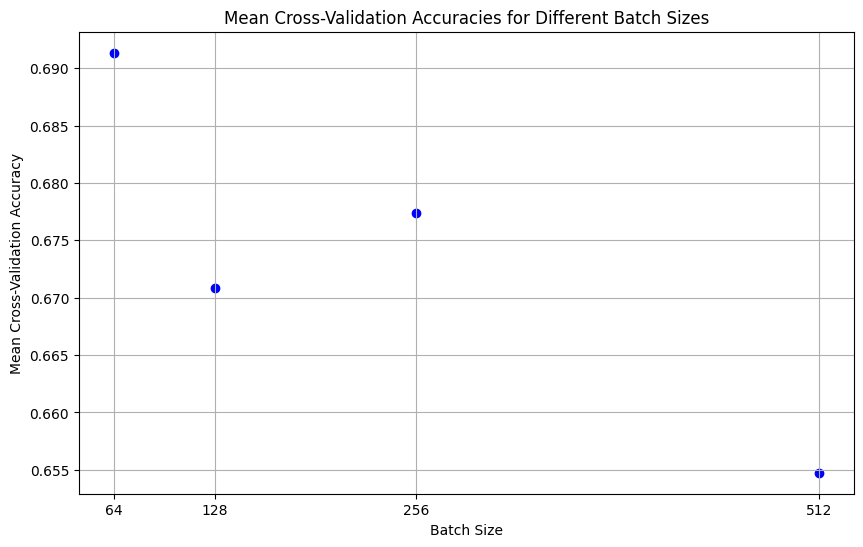

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(cross_validation_accuracies.keys(), cross_validation_accuracies.values(), color='blue')
plt.title('Mean Cross-Validation Accuracies for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.xticks(ticks=batch_sizes, labels = [str(batch_size) for batch_size in batch_sizes])
plt.ylabel('Mean Cross-Validation Accuracy')
plt.grid(True)
plt.show()

4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [10]:
cross_validation_times

{64: 0.3439652442932129,
 128: 0.19534702301025392,
 256: 0.1374824047088623,
 512: 0.10349373817443848}

In [11]:
df = pd.DataFrame({'Batch Size': list(cross_validation_times.keys()),
                   'Last Epoch Time': list(cross_validation_times.values())
                  })

df

,Batch Size,Last Epoch Time
0,64,0.343965
1,128,0.195347
2,256,0.137482
3,512,0.103494


In [1]:
# YOUR CODE HERE
optimal_batch_size = 64
reason = """
# Batch Size Analysis: Trade-off Between Accuracy and Speed

- **Larger batch sizes** generally lead to **faster training** due to:
  - Improved **parallelism**
  - More efficient **matrix operations**
  
- Data analysis shows that increasing the batch size corresponds to **shorter epoch times**.
<br/><br/>

- **Batch Size 64**:
  - Achieves the **highest accuracy** at **69.13%**
  - Computational Time: **0.34 seconds**
  
- **Batch Size 256**:
  - Achieves the **second highest accuracy** of **67.73%** 
  - Computational Time: **0.14 seconds**

A decrease in 1.4% accuracy, led to a a 58% faster computational time

### Recommendations

- For **smaller datasets** (e.g., 9,645 samples), batch size **64** may be preferable to maximize accuracy. Since our data set is small, we will be choose 64 as our optimal sample
- For **larger datasets** (e.g., in the millions), batch size **256** becomes the better choice due to its superior efficiency
"""

# Batch Size Analysis: Trade-off Between Accuracy and Speed

- **Larger batch sizes** generally lead to **faster training** due to:
  - Improved **parallelism**
  - More efficient **matrix operations**
  
- Data analysis shows that increasing the batch size corresponds to **shorter epoch times**.
<br/><br/>

- **Batch Size 64**:
  - Achieves the **highest accuracy** at **69.13%**
  - Computational Time: **0.34 seconds**
  
- **Batch Size 256**:
  - Achieves the **second highest accuracy** of **67.73%** 
  - Computational Time: **0.14 seconds**

A decrease in 1.4% accuracy, led to a a 58% faster computational time

### Recommendations

- For **smaller datasets** (e.g., 9,645 samples), batch size **64** may be preferable to maximize accuracy. Since our data set is small, we will be choose 64 as our optimal sample
- For **larger datasets** (e.g., in the millions), batch size **256** becomes the better choice due to its superior efficiency
